# Assess SeaWiFS error

In [18]:
# imports
from importlib import reload
from importlib.resources import files
import os
import numpy as np

import pandas
import seaborn as sns
from matplotlib import pyplot as plt

from scipy.interpolate import interp1d
from scipy.stats import sigmaclip

from oceancolor.hydrolight import loisel23

from boring.models import anw as boring_anw
from boring.models import bbnw as boring_bbnw
from boring import inference as boring_inf
from boring import rt as boring_rt
from boring import chisq_fit
from boring import plotting

from boring.satellites import seawifs as boring_seawifs

In [3]:
%matplotlib ipympl

# Load SeaWiFS

## Generated here:

## https://seabass.gsfc.nasa.gov/search/?search_type=Perform%20Validation%20Search&val_sata=5&val_products=11&val_source=0

In [4]:
seawifs_file = files('boring').joinpath(os.path.join('data', 'SeaWiFS', 'SeaWiFS_rrs_seabass.csv'))
seawifs = pandas.read_csv(seawifs_file, comment='#')

In [5]:
seawifs.head()

,id,latitude,longitude,date_time,cruise,seawifs_filename,seawifs_es_error,seawifs_pixel_total,seawifs_tdiff,seawifs_solz,...,seawifs_rrs510,seawifs_rrs555,seawifs_rrs670,insitu_rrs412,insitu_rrs443,insitu_rrs490,insitu_rrs510,insitu_rrs555,insitu_rrs670,insitu_data_source
0,1114,45.3139,12.5083,2002-06-20 10:31:00,j5,S2002171114713.L2_MLAC.R0000021033_45N_45N_12E...,1.2,25,5549,24.30,...,0.004992,0.004530,0.000541,0.004656,0.005316,0.007017,0.005890,0.006383,-999.000000,seabass
1,1116,45.3139,12.5083,2002-06-22 10:06:00,j5,S2002173113141.L2_MLAC.R0000021033_45N_45N_12E...,3.9,25,6126,23.08,...,0.006498,0.006172,0.001121,0.004003,0.004418,0.005345,0.004555,0.003585,-999.000000,seabass
2,1121,45.3139,12.5083,2002-06-25 10:27:00,j5,S2002176115745.L2_MLAC.R0000021033_45N_45N_12E...,10.3,25,6411,25.23,...,0.004630,0.004326,0.000458,0.003953,0.004030,0.004809,0.003699,0.002913,-999.000000,seabass
3,1123,45.3139,12.5083,2002-06-27 10:30:00,j5,S2002178114212.L2_MLAC.R0000021033_45N_45N_12E...,12.4,25,5309,23.87,...,0.004121,0.003493,0.000213,0.003588,0.004029,0.004992,0.004312,0.003498,-999.000000,seabass
4,1128,42.3455,-70.5715,2002-07-23 14:40:00,jul02mb,S2002204163422.L2_MLAC.R0000021038_42N_42N_70W...,6.3,25,7855,22.35,...,0.004788,0.004112,0.000748,0.001076,0.001609,0.002380,-999.000000,0.002412,0.000374,seabass


In [6]:
seawifs.keys()

Index(['id', 'latitude', 'longitude', 'date_time', 'cruise',
       'seawifs_filename', 'seawifs_es_error', 'seawifs_pixel_total',
       'seawifs_tdiff', 'seawifs_solz', 'seawifs_senz', 'seawifs_cv',
       'seawifs_windspeed', 'seawifs_rrs412', 'seawifs_rrs443',
       'seawifs_rrs490', 'seawifs_rrs510', 'seawifs_rrs555', 'seawifs_rrs670',
       'insitu_rrs412', 'insitu_rrs443', 'insitu_rrs490', 'insitu_rrs510',
       'insitu_rrs555', 'insitu_rrs670', 'insitu_data_source'],
      dtype='object')

# Calc stats

In [21]:
def calc_stats(tbl, wv):
    diff = tbl[f'seawifs_rrs{wv}'] - tbl[f'insitu_rrs{wv}']
    cut = (np.abs(diff) < 100.) & np.isfinite(tbl[f'seawifs_rrs{wv}']) & (tbl[f'seawifs_rrs{wv}'] > 0.)
    # Sigma clip
    _, low, high = sigmaclip(diff[cut], low=3., high=3.)
    sig_cut = (diff > low) & (diff < high)
    cut &= sig_cut
    #
    std = np.std(diff[cut])
    rel_std = np.std(np.abs(diff[cut])/tbl[f'seawifs_rrs{wv}'][cut])
    # Return
    return diff, cut, std, rel_std

In [22]:
for wv in boring_seawifs.seawifs_wave:
    diff, cut, std, rel_std = calc_stats(seawifs, wv)
    #
    print(f'wv: {wv}, std={std:0.5f} sr^-1, rel_std={10*rel_std:0.2f}%')

wv: 412, std=0.00143 sr^-1, rel_std=34.72%
wv: 443, std=0.00114 sr^-1, rel_std=36.72%
wv: 490, std=0.00091 sr^-1, rel_std=4.28%
wv: 510, std=0.00063 sr^-1, rel_std=2.11%
wv: 555, std=0.00071 sr^-1, rel_std=1.77%
wv: 670, std=0.00026 sr^-1, rel_std=99.60%


# Plots

In [23]:
wv = 510

## Histogram

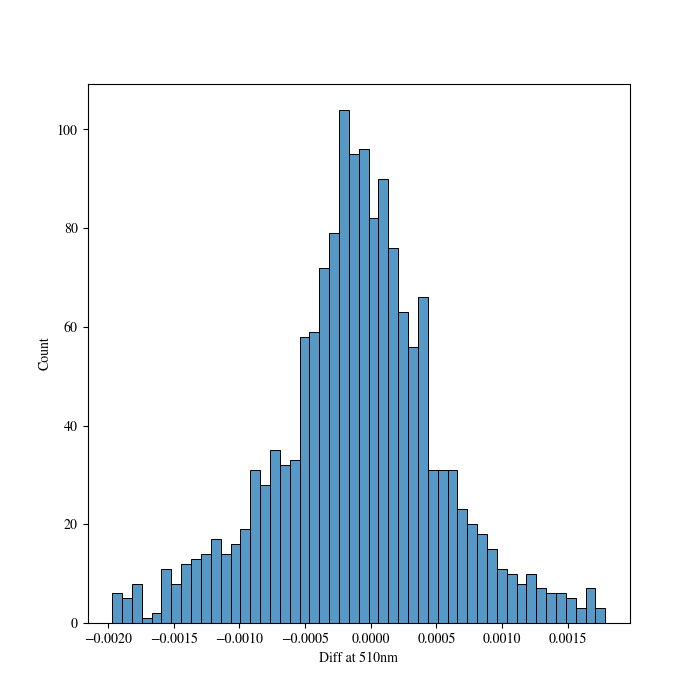

In [24]:
diff, cut, std, rel_std = calc_stats(seawifs, wv)
fig = plt.figure(figsize=(7,7))
ax = plt.gca()
sns.histplot(x=diff[cut], bins=50, ax=ax)
ax.set_xlabel(f'Diff at {wv}nm')
plt.show()

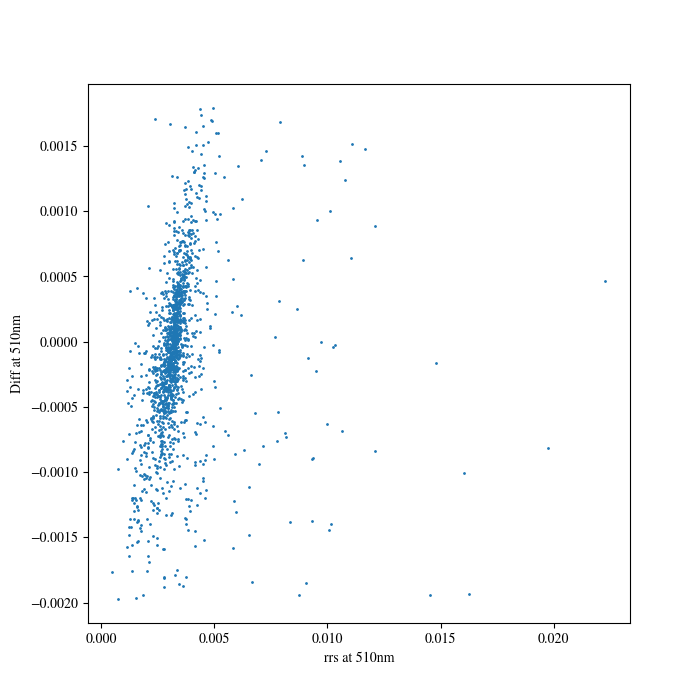

In [25]:
fig = plt.figure(figsize=(7,7))
ax = plt.gca()
#
ax.plot(seawifs[f'seawifs_rrs{wv}'][cut], diff[cut], 'o', ms=1.)
ax.set_ylabel(f'Diff at {wv}nm')
ax.set_xlabel(f'rrs at {wv}nm')
#
plt.show()

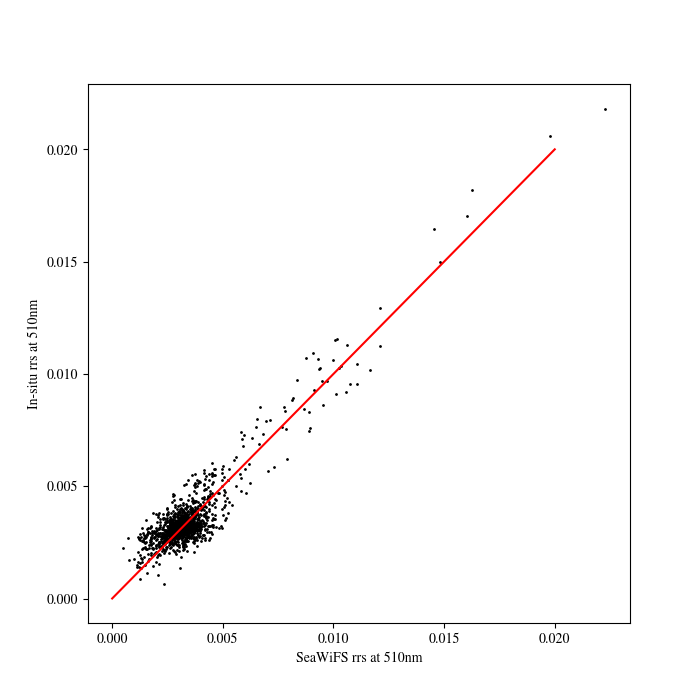

In [27]:
fig = plt.figure(figsize=(7,7))
ax = plt.gca()
#
ax.plot(seawifs[f'seawifs_rrs{wv}'][cut], seawifs[f'insitu_rrs{wv}'][cut], 'ko', ms=1.)
ax.plot([0., 0.02], [0., 0.02], 'r-')
ax.set_xlabel(f'SeaWiFS rrs at {wv}nm')
ax.set_ylabel(f'In-situ rrs at {wv}nm')
#
plt.show()